In [16]:
import pandas as pd
import numpy as np
import altair as alt
df = pd.read_csv("StudyEventTimeSeries.csv")

In [17]:
codelist = list(set(df.as_matrix().flatten()))
codelist.remove(np.nan)
featureOnly= list(filter(lambda x: x.islower(),codelist))

/Users/dorislee/.virtualenvs/py37env/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [18]:
df = df.stack().reset_index()

df = df.rename(columns={
    "level_0":"t",
    "level_1":"user",
    0:"action"
})

In [19]:
def make_session_id(x):
    for index in BR_indices:
        if x<index: 
            return BR_indices.index(index)
    return len(BR_indices)

In [20]:
# Create column called "session_id" containing session number
df_user_lst = []
for user in list(df["user"].unique()):
#     userdf = df[df["user"]==user]
#     userdf[userdf["action"]=="BR"].index.values
    df_tmp = df[(df["user"]==user)&(df["action"]=="BR")]
    df_user = df[(df["user"]==user)]
    BR_indices = list(df_tmp.index.values)
    df_user["session_id"] =list(map(make_session_id, list(df_user.index.values)))
    df_user_lst.append(df_user)

/Users/dorislee/.virtualenvs/py37env/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [21]:
df_session = pd.concat(df_user_lst).reset_index()

In [22]:
df_session["insightful_session"]=False

In [23]:
# Given session_ids, check if IS or ID contained in the session, if so, relabel all the events in the session as being contained in an insightful session
df_user_list = []

for user in df_session['user'].unique():
    df_tmp = df_session[(df_session['user'] == user) & ((df_session['action'] == 'IS') | (df_session['action'] == 'ID'))]
    session_id_true = list(df_tmp['session_id'].unique())
    df_user = df_session[df_session['user'] == user]
    df_user['insightful_session'] = df_session['session_id'].apply(lambda x: True if (x in session_id_true) else False)
    df_user_list.append(df_user)
    #df_session['insightful_session'] = df_session.apply(lambda x: True if ((x['session_id'] in session_id_true) & (x['user'] == user)) else x)

/Users/dorislee/.virtualenvs/py37env/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [24]:
df_user_session_insightfulness = pd.concat(df_user_list)

In [30]:
df_user_session_insightfulness = df_user_session_insightfulness[df_user_session_insightfulness.action.isin(featureOnly)]

In [32]:
df_user_session_insightfulness_freq = df_user_session_insightfulness.groupby(["action","insightful_session"]).count()["t"].reset_index()

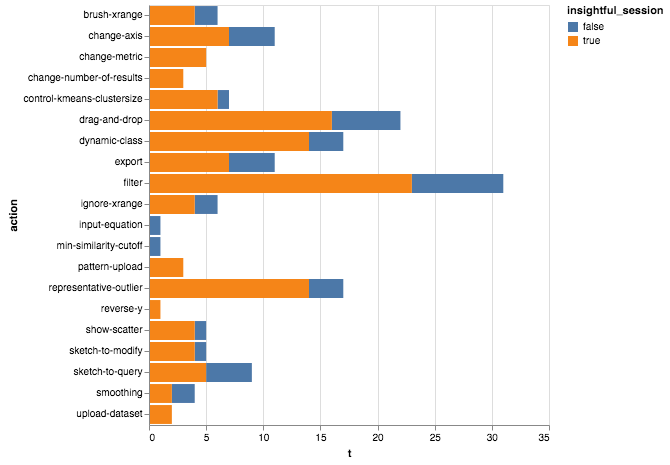

In [34]:
alt.Chart(df_user_session_insightfulness_freq).mark_bar().encode(        
    color='insightful_session',
    y="action",
    x='t'
)

# Compiling everything into sessions

In [26]:
df = pd.read_csv("StudyEventTimeSeries.csv")
sessions=[]
for row in df.as_matrix().T: 
    session=[]
    for action in row:
        if action is not np.NaN:
            if action=="BR":
                if session!=[]:
                    sessions.append(session)
                session=[]
            else:
                session.append(action)
    if session!=[]:
        sessions.append(session)

/Users/dorislee/.virtualenvs/py37env/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [27]:
#Overall Counts
from collections import Counter
overall_sessions_flat  = [item for sublist in sessions  for item in sublist]

In [28]:
print ("Number of sessions with at least one insight:", len(list(filter(lambda x: ('IS' in x) or ('ID' in x),sessions))) )

Number of sessions with at least one insight: 30


In [29]:
insightful_sessions = list(filter(lambda x: ('IS' in x) or ('ID' in x),sessions))

In [45]:
insightful_sessions_flat  = [item for sublist in insightful_sessions  for item in sublist]

In [46]:
insightful_sessions_flat_filtered = list(filter(lambda x: x in featureOnly, insightful_sessions_flat)) #filter out action codes with capital letters

In [47]:
x = Counter(insightful_sessions_flat_filtered)
df = pd.DataFrame(x.most_common(),columns=["Feature","Usage Frequency"])

In [48]:
chart = alt.Chart(df).mark_bar().encode(
    alt.X("Usage Frequency"),#,sort=alt.SortField(field='Usage Frequency', order='descending'))
    alt.Y("Feature")
)

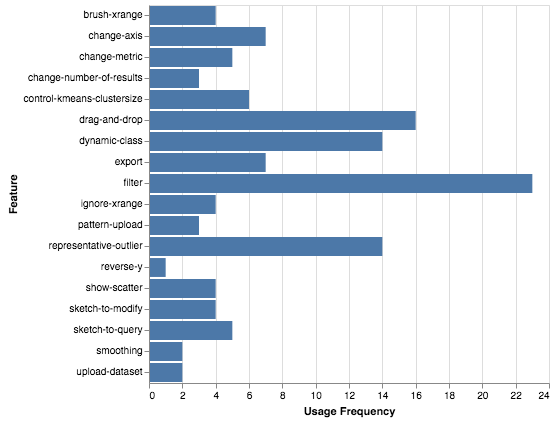

In [49]:
chart